In [1]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

(960, 640, 3)


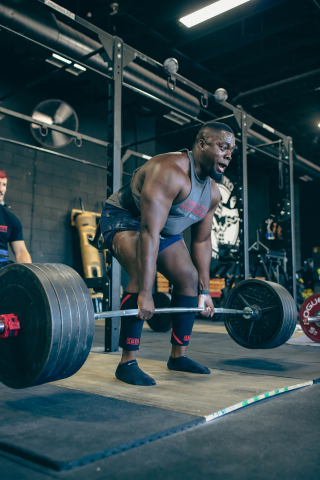

In [2]:
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
import os


#for comfortable viewing only
def resize_and_show(image):
  DESIRED_HEIGHT = 480
  DESIRED_WIDTH = 480
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)


dataset_path = "/content/drive/MyDrive/deadlift_dataset"
images = {}
for filename in os.listdir(dataset_path):
    if os.path.isfile(os.path.join(dataset_path, filename)):
        img = cv2.imread(os.path.join(dataset_path, filename))
        images[filename] = img
        print(img.shape)
        resize_and_show(img)

In [3]:
import mediapipe as mp
#model init
mp_pose = mp.solutions.pose
#results visualize init
mp_drawing = mp.solutions.drawing_utils
#styles for visulization init
mp_drawing_styles = mp.solutions.drawing_styles

# Пример нормализованных координат с origin'ом между бедрами
 - не подходит для оценки глубины

Nose coordinates: (0.7161749005317688, 0.3298127055168152,-0.7671926617622375)
Pose landmarks of 1.webp:


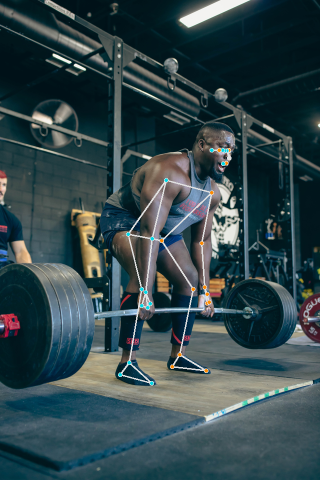

In [4]:
#model run and draw skeleton landmarks
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
  for name, image in images.items():
    #Convert the BGR image to RGB and process it with MediaPipe Pose.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    #Print nose landmark.
    image_hight, image_width, _ = image.shape
    if not results.pose_landmarks:
      continue
    print(
      f'Nose coordinates: ('
      f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x}, '
      f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y},'
      f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].z})'
    )

    #Draw pose landmarks.
    print(f'Pose landmarks of {name}:')
    annotated_image = image.copy()
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    resize_and_show(annotated_image)

# Пример координат world_pose_landmark.
 - Плюсом выступает тот факт, что глубина здесь измерена более точно
 - Минус в том, что определение origin'а полностью переходит в зону ответственности модели

Nose world landmark:
x: 0.4203752279281616
y: -0.34417539834976196
z: -0.4536173641681671
visibility: 0.9999804496765137



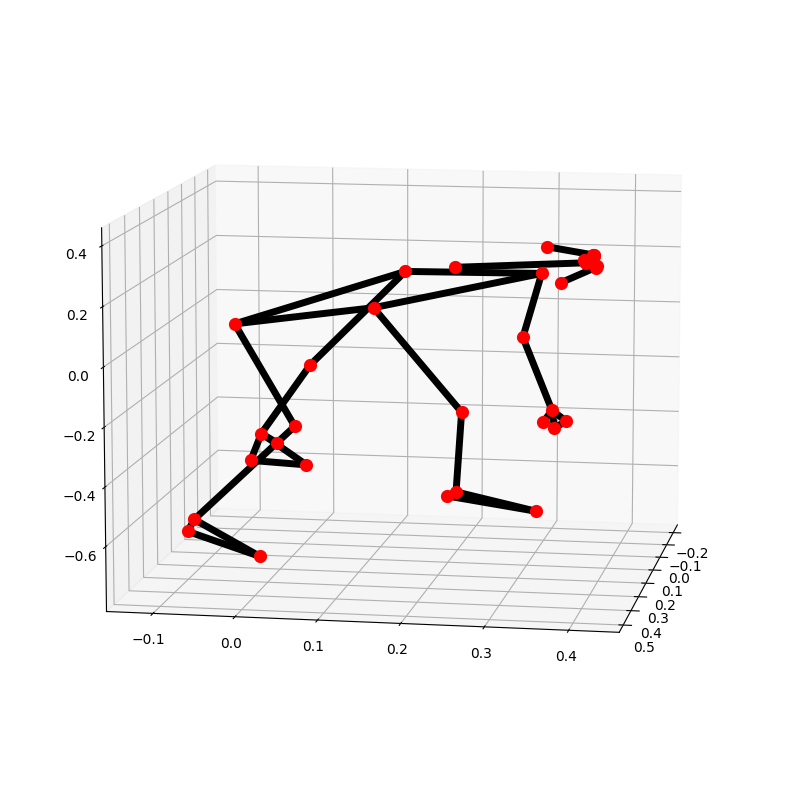

In [5]:
# Run MediaPipe Pose and plot 3d pose world landmarks.
with mp_pose.Pose(
    static_image_mode=True, min_detection_confidence=0.5, model_complexity=2) as pose:
  for name, image in images.items():
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print the real-world 3D coordinates of nose in meters with the origin at
    # the center between hips.
    print('Nose world landmark:'),
    print(results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.NOSE])

    #Plot pose world landmarks.
    mp_drawing.plot_landmarks(
        results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [67]:
import pandas as pd
if results.pose_world_landmarks.landmark:
  index = 0
  row = list()
  for lms in results.pose_world_landmarks.landmark:
    row.append(lms.x)
    row.append(lms.y)
    row.append(lms.z)

In [88]:
df = pd.read_csv('/content/drive/MyDrive/dataset_for_deadlift.csv')
df.loc[-1] = row
df

,x_0.nose,y_0.nose,z_0.nose,x_1.left_eye_inner,y_1.left_eye_inner,z_1.left_eye_inner,x_2.left_eye,y_2.left_eye,z_2.left_eye,x_3.left_eye_inner,...,z_29.left_heel,x_30.right_heel,y_30.right_heel,z_30.right_heel,x_31.left_foot_index,y_31.left_foot_index,z_31.left_foot_index,x_32.right_foot_index,y_32.right_foot_index,z_32.right_foot_index
0,0.420375,-0.344175,-0.453617,0.41626,-0.3779,-0.440576,0.415198,-0.372552,-0.43059,0.41435,...,0.213503,-0.117746,0.697221,-0.2015,0.284644,0.737624,0.152535,-0.006898,0.72291,-0.31547
1,0.420375,-0.344175,-0.453617,0.41626,-0.3779,-0.440576,0.415198,-0.372552,-0.43059,0.41435,...,0.213503,-0.117746,0.697221,-0.2015,0.284644,0.737624,0.152535,-0.006898,0.72291,-0.31547
-1,0.420375,-0.344175,-0.453617,0.41626,-0.3779,-0.440576,0.415198,-0.372552,-0.43059,0.41435,...,0.213503,-0.117746,0.697221,-0.2015,0.284644,0.737624,0.152535,-0.006898,0.72291,-0.31547


In [87]:
df.to_csv('/content/drive/MyDrive/dataset_for_deadlift.csv', index=False)